<a href="https://colab.research.google.com/github/JARACH-209/Cloud_Lab/blob/master/Cloud_Lab9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import math
%matplotlib inline

df = pd.read_csv("/content/adult_cleaned.csv")

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   39      32560 non-null  int64 
 1   13      32560 non-null  int64 
 2    Male   32560 non-null  object
 3   40      32560 non-null  int64 
 4    <=50K  32560 non-null  object
dtypes: int64(3), object(2)
memory usage: 1.2+ MB


In [27]:
df[' Male'].replace(to_replace = ' Male',value = 1,inplace=True)
df[' Male'].replace(to_replace = ' Female',value = 0,inplace=True)
df[' <=50K'].replace(to_replace = ' <=50K',value = 0,inplace=True)
df[' <=50K'].replace(to_replace = ' >50K',value = 1,inplace=True)

In [32]:
df.head(3)

,39,13,Male,40,<=50K
0,50,13,1,13,0
1,38,9,1,40,0
2,53,7,1,40,0


In [37]:
Y = df[' <=50K'].to_numpy()
df.drop(columns=['13',' <=50K'],inplace=True)
X = df.to_numpy()

In [87]:
class K_Means():
    def __init__(self,k=1,iterations = 100,elbow=False,k_max=10):
        self.k = k
        self.iterations = iterations
        self.elbow_flag = elbow
        self.k_max = k_max
        self.best_k = None
        self.elbow_reductions = None
        self.k_centroids = None
        self.y = None
        self.variances = None

    def final_centroids(self):
        return np.array(self.k_centroids)

    def get_variance(self,X,y,k_centroids):
        # sum of squares of distances between points and their centroids
        temp = 0
        for j in range(len(k_centroids)):
            for point,cluster in zip(X,y):
                if cluster == j:
                    temp += self.euclidean_distance(point,k_centroids[j])**2 
        return math.sqrt(temp)

    def euclidean_distance(self, p1, p2):
        # math.dist can gives distance between points of any dimensionality 
        # Unfortunately Colab works on python3.6 and dist is in 3.8
        #return math.dist(p1,p2)     
        return np.linalg.norm(p1-p2)

    def get_centroids(self,X,y,k):
        k_centroids = []
        cluster_indexes = []
        for j in range(k):
            cluster_indexes.append([i for i in range(len(y)) if y[i] == j])
        # Finding means of all the clusters
        # Summing all the coordinates in all the dimensions having same cluster 
        # label and taking a mean
        for cluster in cluster_indexes:
            cluster_mean = 0
            for i in cluster:
                 cluster_mean += X[i]
            num = len(cluster) if len(cluster) >0 else 1
            k_centroids.append(np.array(cluster_mean/num))
            
            # k = number of clusters and their labels as well.
            # Taking mean of all the points having same cluster label 
            # To get the mean coordinates find the mean of all the dimensional coordinates
            # E.g -> [x,y,z] otherwise mean will be a number and for distance dims must be equal
            # experession below will give direct mean instead of coordinates.
        # k_centroids.append((np.mean([point for point,cluster in zip(X,y) if cluster == j])))
        return k_centroids

    def get_cluster(self,X,k_centroids):
        y = np.zeros(len(X),dtype=int)
        min_dist = None
        cluster = 0
        dist = None
        for i in range(len(X)):
            
            min_dist = self.euclidean_distance(X[i],k_centroids[0])
            cluster = 0
            for j in range(len(k_centroids)):
                dist = self.euclidean_distance(X[i],k_centroids[j])
                if dist < min_dist:
                    min_dist = dist
                    cluster = j
            y[i] = int(cluster)
        return y

    def clustering(self,X, k):
        min_variance = None
        variance = None
        best_centroids = None
        variances = np.zeros(self.iterations)
        for i in range(self.iterations):
            y = np.zeros(len(X),dtype=int)
            k_centroids = []
            variance = []

            # intializes distinct random k points from dataset
            while True:
                rand_points = np.random.randint(len(X),size=(k))
                if len(set(rand_points)) == len(rand_points):
                    break
            for points in rand_points:
                k_centroids.append(X[points])
            min_variance = self.get_variance(X,y,k_centroids)
            check_count = 0

            print("Iteration ",i)

            # Clustering Loop
            while True:
                check_count += 1
                # Prevents the loop from going to infinity in any possible case
                if check_count > len(X)*10:
                    raise Exception("Error in Cluster Loop. Infite Looping. Run again.") 
                
                # cluster labeling with given centroids
                y = self.get_cluster(X,k_centroids) 
                
                # Generates new centroids by taking mean of all labels
                new_centroids = self.get_centroids(X,y,k)
                if np.array_equal(k_centroids,new_centroids):
                    variance = self.get_variance(X,y,new_centroids)
                    break
                else:
                    k_centroids = new_centroids

            variances[i] = variance
            if variance < min_variance:
                min_variance = variance
                best_centroids = k_centroids
        self.variances = variances
        return best_centroids,min_variance

    def elbow_clustering(self,X):
        var_reductions = np.zeros(self.k_max+1)
        variance = None
        variances = []
        for i in range(1,int(self.k_max+1)):
            _, variance = self.clustering(X,i)
            variances.append(variance)
        for i in range(len(variances)-1):
            var_reductions[i+1] = abs(variances[i+1]-variances[i])
        self.elbow_reductions = var_reductions
        self.variances = variances
        return var_reductions

    def fit(self, X):
        best_k = None
        k = self.k
        centroids = []
        y = []
        if self.elbow_flag:

            #Gives variances for all the values of K
            #implement automation later
            self.elbow_clustering(X)

        else:
            centroids, min_var = self.clustering(X,k) #final centroids are stored globally
            y = self.get_cluster(X, centroids)
            self.k_centroids = centroids
            self.y = y
            return y
            

In [88]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

In [89]:
clf = K_Means(2,iterations = 50)
y_pred = clf.fit(X)

Iteration  0
Iteration  1
Iteration  2
Iteration  3
Iteration  4
Iteration  5
Iteration  6
Iteration  7
Iteration  8
Iteration  9
Iteration  10
Iteration  11
Iteration  12
Iteration  13
Iteration  14
Iteration  15
Iteration  16
Iteration  17
Iteration  18
Iteration  19
Iteration  20
Iteration  21
Iteration  22
Iteration  23
Iteration  24
Iteration  25
Iteration  26
Iteration  27
Iteration  28
Iteration  29
Iteration  30
Iteration  31
Iteration  32
Iteration  33
Iteration  34
Iteration  35
Iteration  36
Iteration  37
Iteration  38
Iteration  39
Iteration  40
Iteration  41
Iteration  42
Iteration  43
Iteration  44
Iteration  45
Iteration  46
Iteration  47
Iteration  48
Iteration  49


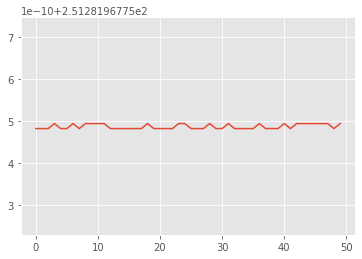

In [95]:
plt.plot(range(len(variances)), variances)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

<Figure size 720x720 with 0 Axes>

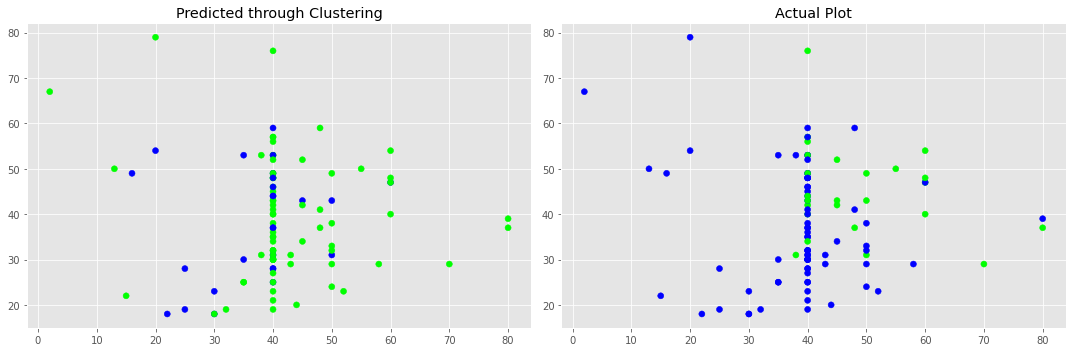

In [66]:
plt.figure(figsize=(10,10))
plt.style.use('ggplot')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].scatter(df['40'][:100],df['39'][:100],c=y_pred[:100],cmap='brg')
axes[1].scatter(df['40'][:100],df['39'][:100],c=Y[:100],cmap='brg')
axes[0].title.set_text("Predicted through Clustering")
axes[1].title.set_text("Actual Plot")
fig.tight_layout()